In [454]:
import pandas as pd
import numpy as np
import yfinance as yfinance
import matplotlib.pyplot as plt
import seaborn as sns

### Set Variables

In [455]:

ticker = 'SPY'
startDate = '2021-01-01'
endDate = '2022-12-31'
dataInterval = '1d'

# moving average period
rollingPeriod = 21

# entry ratio
entryPercentile = 0.10

# exit ratio
exitPercentile = 0.90

### Get Data

In [456]:
df = yf.download(ticker, startDate, endDate, interval = dataInterval)
df.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


### Define strategy 


    Idea: 
        Enter and Exit based on exterme price movement relative to the prior rolling min/max of close
        
    Data: 
        1. Rolling N period min and max of close 
        2. Ratio of current price relative to the rolling min/max of close
        3. The top and bottom rolling percentile of ratios
        
    Entry:
        Enter trade when price hits the top band
        
    Exit:
        Exit trade when price hits the bottom band



In [457]:
def roiBandStrategy(close_):
    # get prior highs and lows
    prior_max = max(close_)
    prior_min = min(close_)
    
    # get ratio from prior high/low
    ratio_from_high = close_[-1] / prior_max - 1
    ratio_from_low = close_[-1] / prior_min - 1
    
    
    return prior_max, prior_min, ratio_from_high, ratio_from_low

### Apply function to data

In [458]:
# apply function to data
event_date = []
close_price = []
prior_max_ = []
prior_min_ = []
ratio_from_high_ = []
ratio_from_low_ = []

queryData = list(df['Close'])
queryDate = list(df['Date']) or list(df['Dateime'])
for i in range(len(queryData)):
    
    data = queryData[i:i+rollingPeriod]
    date = queryDate[i:i+rollingPeriod]
    
    if len(data) == rollingPeriod:
        prior_max, prior_min, ratio_from_high, ratio_from_low = roiBandStrategy(data)
        
        event_date.append(date[-1])
        close_price.append(data[-1])
        
        prior_max_.append(prior_max)
        prior_min_.append(prior_min)
        ratio_from_high_.append(ratio_from_high)
        ratio_from_low_.append(ratio_from_low)


In [459]:
# get percentiles 

ratio_from_high_pct = [0] * (rollingPeriod-1)
ratio_from_low_pct = [0] * (rollingPeriod-1)

for i in range(len(ratio_from_high_)):
    
    data_high = ratio_from_high_[i:i+rollingPeriod]
    data_low = ratio_from_low_[i:i+rollingPeriod]
    
    if (len(data_high) == rollingPeriod) & (len(data_low) == rollingPeriod):
        ratio_from_high_pct.append(np.quantile(data_high, entryPercentile))
        ratio_from_low_pct.append(np.quantile(data_low, exitPercentile))
    

In [460]:
# convert list to dataframe
data = {
    'event_date': event_date,
    'close_price': close_price,
    'prior_max_': prior_max_,
    'prior_min_': prior_min_,
    'ratio_from_high_': ratio_from_high_,
    'ratio_from_low_': ratio_from_low_,
    'ratio_from_high_pct': ratio_from_high_pct,
    'ratio_from_low_pct': ratio_from_low_pct
}
data = pd.DataFrame(data)

In [461]:
### Get bootstrapped roi means

In [462]:
# calculate the bootstap means

iterations = 1000
boot_ratio_from_high_mean = []
boot_ratio_from_low__mean = []

for _ in range(iterations):
    boot_ratio_from_high_ = np.random.choice(data['ratio_from_high_'],replace = True, size = iterations)
    boot_ratio_from_high_mean.append(np.mean(boot_ratio_from_high_))
    
    boot_ratio_from_low_ = np.random.choice(data['ratio_from_low_'],replace = True, size = iterations)
    boot_ratio_from_low__mean.append(np.mean(boot_ratio_from_low_))
  

In [463]:
# Exit logic
data['above'] = 0
data.loc[data['ratio_from_low_'] > data['ratio_from_low_pct'],'above'] = 1
data['above_rolling5'] = data['above'].rolling(5).sum()

# if trigger was on for atleast 3 days, and trigger is off today, and the rolling roi exceeds the mean
#    exit trade tomorrow
data['entry_sell'] = 0
data.loc[(data['above_rolling5']>=3) & (data['above']==0) & (
    data['ratio_from_low_']>= np.mean(boot_ratio_from_low__mean)),'entry_sell'] = 1


# entry df
entry_sell = data[data['entry_sell']==1]

In [464]:
# # Entry logic
data['below'] = 0
data.loc[data['ratio_from_high_'] < data['ratio_from_high_pct'],'below'] = 1
data['below_rolling5'] = data['below'].rolling(5).sum()

# if trigger was on for atleast 3 days, and trigger is off today, and the rolling roi exceeds the mean
#    enter trade tomorrow

data['entry_buy'] = 0
data.loc[(data['below_rolling5']>=3) & (data['below']==0) & (
    data['ratio_from_high_'] <= np.mean(boot_ratio_from_high_mean)),'entry_buy'] = 1

# entry df
entry_buy = data[data['entry_buy']==1]


# Plot Strategy 

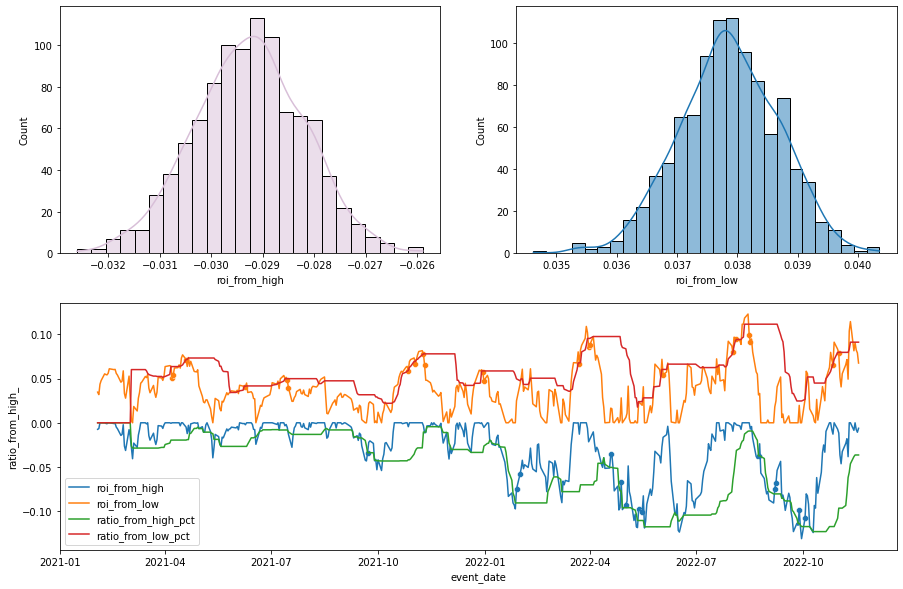

boot_ratio_from_low__mean:  0.037857531007346096
boot_ratio_from_high_mean:  -0.029265966155662546


In [465]:
fig = plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.histplot(boot_ratio_from_high_mean, color= 'thistle', kde=True).set(xlabel='roi_from_high')

plt.subplot(2,2,2)
sns.histplot(boot_ratio_from_low__mean, kde=True).set(xlabel='roi_from_low')

plt.subplot(2,1,2)
sns.lineplot(x=data['event_date'],y=data['ratio_from_high_'], label='roi_from_high')
sns.lineplot(x=data['event_date'],y=data['ratio_from_low_'], label='roi_from_low')

sns.scatterplot(data=entry_buy, x="event_date", y="ratio_from_high_")
sns.scatterplot(data=entry_sell, x="event_date", y="ratio_from_low_")


sns.lineplot(x=data['event_date'],y=data['ratio_from_high_pct'], label='ratio_from_high_pct')
sns.lineplot(x=data['event_date'],y=data['ratio_from_low_pct'], label='ratio_from_low_pct')


plt.show()

print("boot_ratio_from_low__mean: ",np.mean(boot_ratio_from_low__mean))
print("boot_ratio_from_high_mean: ",np.mean(boot_ratio_from_high_mean))

### Get Backtesting Results

In [466]:
df_backtest = pd.read_csv('results.csv')
data['event_date'] = [str(x)[:10] for x in data['event_date']]


In [467]:
print(df_backtest.shape)
print(data.shape)

(454, 7)
(455, 14)


In [468]:
df_backtest.head()

,Unnamed: 0,Date,Close,roi_from_high,roi_from_low,roi_from_high_10th_pct,roi_from_low_90th_pct
0,0,2021-02-03,381.850006,-0.006608,0.031832,-0.006608,0.031832
1,1,2021-02-04,386.190002,0.000000,0.043559,-0.005947,0.042387
2,2,2021-02-05,387.709991,0.000000,0.047667,-0.005286,0.046845
3,3,2021-02-08,390.510010,0.000000,0.055233,-0.004626,0.052963
4,4,2021-02-09,390.250000,-0.000666,0.054530,-0.004231,0.054952


In [469]:
data.head()

,event_date,close_price,prior_max_,prior_min_,ratio_from_high_,ratio_from_low_,ratio_from_high_pct,ratio_from_low_pct,above,above_rolling5,entry_sell,below,below_rolling5,entry_buy
0,2021-02-02,381.549988,384.390015,368.790009,-0.007388,0.034600,0.0,0.0,1,NaN,0,1,NaN,0
1,2021-02-03,381.850006,384.390015,370.070007,-0.006608,0.031832,0.0,0.0,1,NaN,0,1,NaN,0
2,2021-02-04,386.190002,386.190002,370.070007,0.000000,0.043559,0.0,0.0,1,NaN,0,0,NaN,0
3,2021-02-05,387.709991,387.709991,370.070007,0.000000,0.047667,0.0,0.0,1,NaN,0,0,NaN,0
4,2021-02-08,390.510010,390.510010,370.070007,0.000000,0.055233,0.0,0.0,1,5.0,0,0,2.0,0


In [470]:
compare_df = data.merge(df_backtest, how = "left", left_on = 'event_date', right_on = 'Date')
compare_df.dropna(inplace=True)

In [471]:
compare_df['diff_close'] = compare_df['Close'] - compare_df['close_price']
compare_df['diff_roi_from_high'] = compare_df['roi_from_high'] - compare_df['ratio_from_high_']
compare_df['diff_roi_from_low'] = compare_df['roi_from_low'] - compare_df['ratio_from_low_']
compare_df['diff_roi_from_high_10th_pct'] = compare_df['roi_from_high_10th_pct'] - compare_df['ratio_from_high_pct']
compare_df['diff_roi_from_low_90th_pct'] = compare_df['roi_from_low_90th_pct'] - compare_df['ratio_from_low_pct']

In [472]:
compare_df.tail()

,event_date,close_price,prior_max_,prior_min_,ratio_from_high_,ratio_from_low_,ratio_from_high_pct,ratio_from_low_pct,above,above_rolling5,...,Close,roi_from_high,roi_from_low,roi_from_high_10th_pct,roi_from_low_90th_pct,diff_close,diff_roi_from_high,diff_roi_from_low,diff_roi_from_high_10th_pct,diff_roi_from_low_90th_pct
450,2022-11-14,395.119995,398.51001,365.410004,-0.008507,0.081306,-0.038276,0.091037,0,2.0,...,395.119995,-0.008507,0.081306,-0.038276,0.091037,0.0,1.734723e-18,0.000000e+00,0.0,0.0
451,2022-11-15,398.489990,398.51001,365.410004,-0.000050,0.090528,-0.036373,0.091037,0,2.0,...,398.489990,-0.000050,0.090528,-0.036373,0.091037,0.0,-6.776264e-21,0.000000e+00,0.0,0.0
452,2022-11-16,395.450012,398.51001,365.410004,-0.007679,0.082209,-0.036373,0.091037,0,2.0,...,395.450012,-0.007679,0.082209,-0.036373,0.091037,0.0,8.673617e-19,0.000000e+00,0.0,0.0
453,2022-11-17,394.239990,398.51001,365.410004,-0.010715,0.078898,-0.036373,0.091037,0,1.0,...,394.239990,-0.010715,0.078898,-0.036373,0.091037,0.0,0.000000e+00,0.000000e+00,0.0,0.0
454,2022-11-18,396.029999,398.51001,371.010010,-0.006223,0.067438,-0.036373,0.091037,0,0.0,...,396.029999,-0.006223,0.067438,-0.036373,0.091037,0.0,0.000000e+00,-1.387779e-17,0.0,0.0


In [473]:
# check if spead is zero

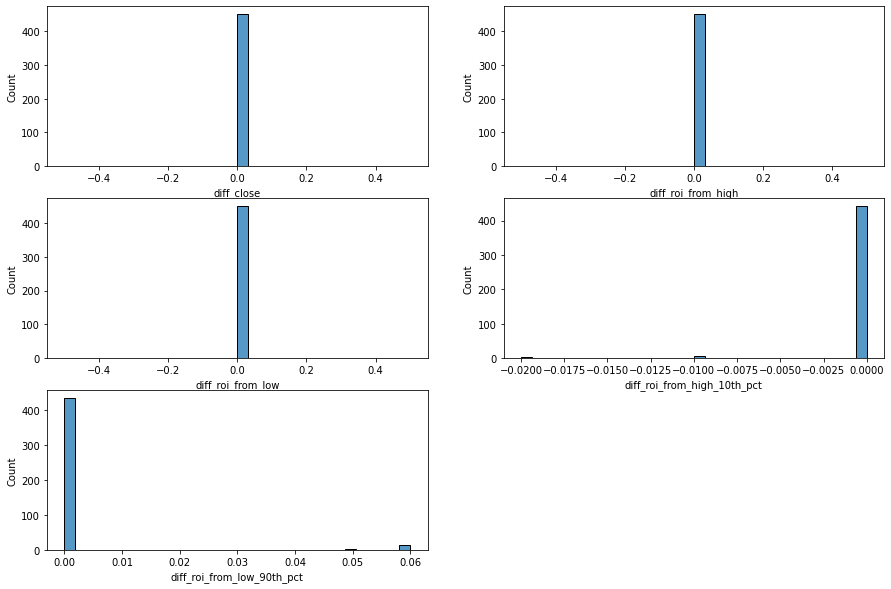

In [474]:
fig = plt.figure(figsize=(15,10))

plt.subplot(3,2,1)
sns.histplot(compare_df['diff_close'].round(2),bins=32).set(xlabel='diff_close')

plt.subplot(3,2,2)
sns.histplot(compare_df['diff_roi_from_high'].round(2),bins=32, kde=False).set(xlabel='diff_roi_from_high')

plt.subplot(3,2,3)
sns.histplot(compare_df['diff_roi_from_low'].round(2),bins=32, kde=False).set(xlabel='diff_roi_from_low')

plt.subplot(3,2,4)
sns.histplot(compare_df['diff_roi_from_high_10th_pct'].round(2),bins=32, kde=False).set(xlabel='diff_roi_from_high_10th_pct')

plt.subplot(3,2,5)
sns.histplot(compare_df['diff_roi_from_low_90th_pct'].round(2),bins=32, kde=False).set(xlabel='diff_roi_from_low_90th_pct')


plt.show()


In [475]:
# ensure strategy in notebook matches backtest results

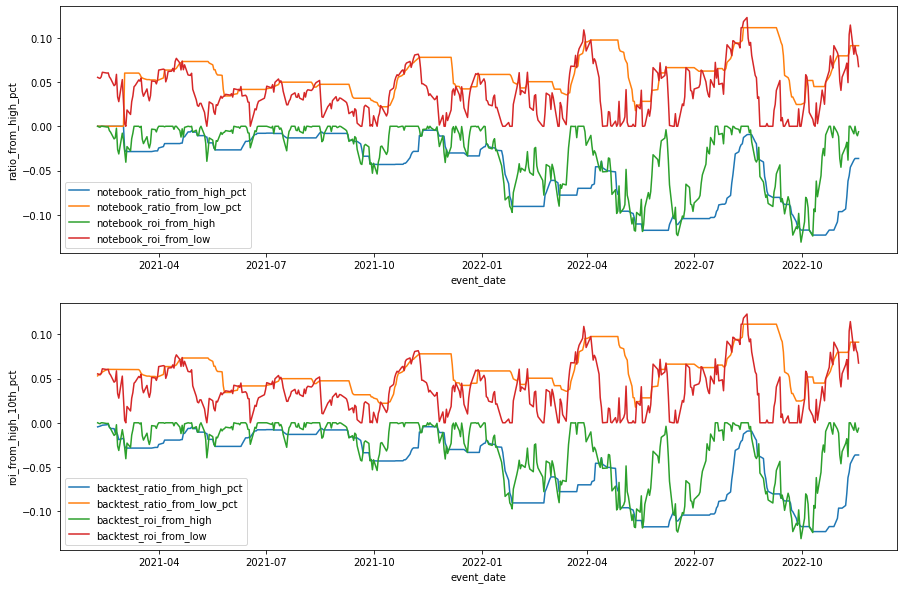

In [476]:
compare_df['event_date'] = pd.to_datetime(compare_df['event_date'])

fig = plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
sns.lineplot(x=compare_df['event_date'],y=compare_df['ratio_from_high_pct'], label='notebook_ratio_from_high_pct')
sns.lineplot(x=compare_df['event_date'],y=compare_df['ratio_from_low_pct'], label='notebook_ratio_from_low_pct')

sns.lineplot(x=compare_df['event_date'],y=compare_df['ratio_from_high_'], label='notebook_roi_from_high')
sns.lineplot(x=compare_df['event_date'],y=compare_df['ratio_from_low_'], label='notebook_roi_from_low')

plt.subplot(2,1,2)

sns.lineplot(x=compare_df['event_date'],y=compare_df['roi_from_high_10th_pct'], label='backtest_ratio_from_high_pct')
sns.lineplot(x=compare_df['event_date'],y=compare_df['roi_from_low_90th_pct'], label='backtest_ratio_from_low_pct')

sns.lineplot(x=compare_df['event_date'],y=compare_df['roi_from_high'], label='backtest_roi_from_high')
sns.lineplot(x=compare_df['event_date'],y=compare_df['roi_from_low'], label='backtest_roi_from_low')



plt.show()
